# Neural Networks
Neural networks are a type of computational model inspired by the structure and functioning of the human brain. Neural networks consist of interconnected nodes, known as artificial neurons or "nodes," which are organized in layers. These layers can be grouped into an input layer, one or more hidden layers, and an output layer.

Each artificial neuron receives input signals, performs a computation on them, and produces an output signal. The strength of the connections between neurons, represented by numerical values called weights, determines the influence of each input on the neuron's computation. Additionally, each neuron typically has an associated bias value that helps adjust the output.

The computations performed by neural networks are based on simple mathematical operations and activation functions. Activation functions introduce non-linearities into the system, enabling neural networks to model complex relationships between inputs and outputs.

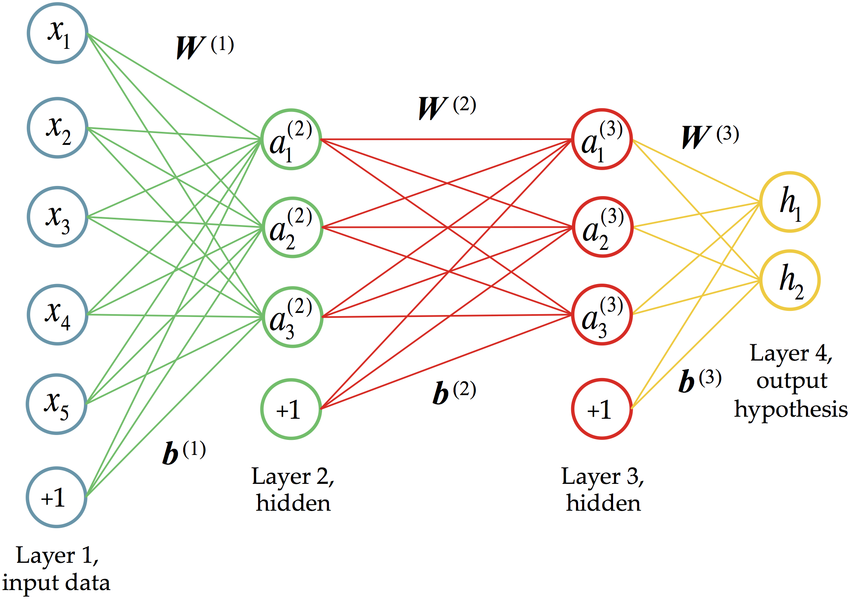

#### Let's see an example of neural network using Tensorflow and Keras

In [1]:
# temp: creation fo dataset, delete after created
import numpy as np
import pandas as pd

coffee_df = pd.read_csv('./data/coffee_roasting.csv')
coffee_df.head()

Temperature       Time  Good_roast
0   185.317638  12.693965           1
1   259.920475  11.867664           0
2   231.013571  14.414242           0
3   175.366645  11.720587           0
4   187.120865  14.129732           1

#### Coffee roast data set
First let's load a coffee roasting data set, where we have two features: Time of roasting (in minutes) and Temperature of roasting (in Celsius). Target is whether the roast is good or bad. There is simple rule we know even before using neural network, but let's us try whether simple neural network can discover this rule base on our dataset.

Simple rules for good roast: <br>
1) best temperature: 175 - 260° <br>
2) best time: 12 - 15 min <br>
3) $ time <= \frac{-3}{(260-175)*temperature}+21 $ <br>

#### Visualization of the dataset

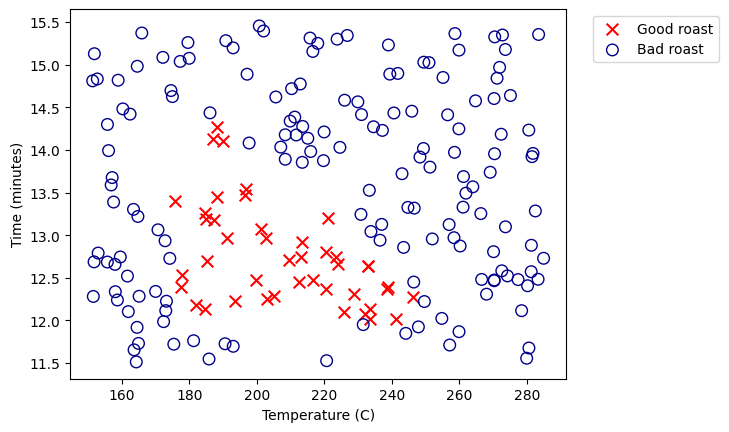

In [2]:
import matplotlib.pyplot as plt
good_roast = coffee_df[coffee_df['Good_roast']==1]; bad_roast = coffee_df[coffee_df['Good_roast']==0]

fix, ax = plt.subplots()
ax.scatter(good_roast.Temperature, good_roast.Time, s=70, marker='x', c='r', label='Good roast')
ax.scatter(bad_roast.Temperature, bad_roast.Time, s=70, marker='o', label='Bad roast', facecolors='none', edgecolors='darkblue')
ax.set(ylabel = 'Time (minutes)',
       xlabel = 'Temperature (C)')
ax.legend(loc='upper left', bbox_to_anchor=(1.04, 1), fancybox=True, ncol=1)
plt.show()

#### Now we will implement simple neural network using keras library. The NN will have only 1 hidden layer with 3 nodes and output layer returning a probability that the roast is good.

In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import tensorflow as tf

tf.random.set_seed(1234)  # applied to achieve consistent results

#building a simple model
model = Sequential(
    [
        tf.keras.Input(shape=(2,)),
        Dense(3, activation='sigmoid', name='layer1'),
        Dense(1, activation='sigmoid', name='layer2')
    ]
)

model.compile(
    loss = tf.keras.losses.BinaryCrossentropy(),
    optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.01),   #using legacy.Adam for mac M1, M2 otherwise use just .Adam
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 layer1 (Dense)              (None, 3)                 9         
                                                                 
 layer2 (Dense)              (None, 1)                 4         
                                                                 
Total params: 13 (52.00 Byte)
Trainable params: 13 (52.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Before we start to train the model we need to normalize feature columns.

In [11]:
X = coffee_df.iloc[:,:-1].to_numpy()
y = coffee_df.iloc[:,-1].to_numpy()

norm_1 = tf.keras.layers.Normalization(axis=-1)
norm_1.adapt(X)
X_n = norm_1(X)

##### Since our data set has only 200 records, we will oversample the whole population. Then we can youse less epochs to achieve good result

In [13]:
X_t = np.tile(X_n,(1000,1))
y_t = np.tile(y,(1000,)) 

model.fit(X_t, y_t, epochs=10, verbose=0)

In [32]:
w1, b1 = model.get_layer('layer1').get_weights()
w2, b2 = model.get_layer('layer2').get_weights()

print(f'layer 1 weights: \n{w1}')
print(f'layer 1 biases: \n{b1}')

print(f'layer 2 weights: \n{w2}')
print(f'layer 2 biases: \n{b2}')

layer 1 weights: 
[[  0.2599205 -11.652566   15.633943 ]
 [ 11.021235   -0.3331931  12.950254 ]]
layer 1 biases: 
[ 13.238543 -12.460113   2.288495]
layer 2 weights: 
[[ 58.48373 ]
 [-69.85993 ]
 [-58.026566]]
layer 2 biases: 
[-17.640139]


##### Now we have trained our model. Let's generate dataset of all possible temperatures and times to see how the model predicts whether the roast is good or bad

##### We can visualize it using a scale from 0 - 1 (probability) that for defined features the roast is good

In [37]:
#gen all possible data to predict
X_pred = np.mgrid[150:291:1, 11.5:15.6:0.1].reshape(2,-1).T

X_pred_t = norm_1(X_pred)   # normalize accoring to training data
y_pred = model.predict(X_pred_t)  #make prediction

181/181 [==============================] - 0s 259us/step


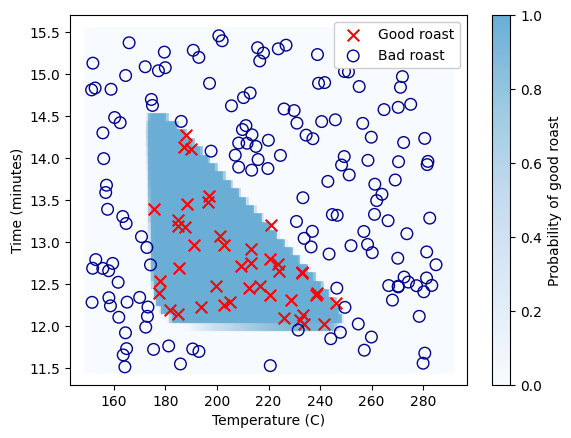

In [38]:
#visualize predictions as a heatmap
from matplotlib import cm
import matplotlib.colors as colors

# y_pred = y_pred.reshape(-1,)

#function helping to reduce undelying color
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    """ truncates color map """
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

#defining colors
cmap = plt.get_cmap('Blues')
new_cmap = truncate_colormap(cmap, 0.0, 0.5)

# plotting prediction map with training data
fig, ax = plt.subplots()
sc = ax.scatter(X_pred[:,0], X_pred[:,1], c=y_pred, cmap=new_cmap, marker='s', norm=cm.colors.Normalize(vmin=0, vmax=1))
ax.scatter(good_roast.Temperature, good_roast.Time, s=70, marker='x', c='r', label='Good roast')
ax.scatter(bad_roast.Temperature, bad_roast.Time, s=70, marker='o', label='Bad roast', facecolors='none', edgecolors='darkblue')
ax.set(ylabel = 'Time (minutes)',
       xlabel = 'Temperature (C)')
ax.legend(loc='upper right', bbox_to_anchor=(1.0, 1), fancybox=True, ncol=1, framealpha=1)
ax.figure.colorbar(sc, ax=ax, label= 'Probability of good roast')
plt.show()

### We can see that our simple model performs pretty well. The model was able to generalize the rules we set in in the begging and the shape with highest probaility of a good roast is a "triangle" fulfilling our rules.

## Now let's build our own NN to illustrate how neural networks work.

### Forward propagation in NumPy

In [18]:
# use activation function sigmoid
def sigmoid(x):
    return 1 / (1+ np.exp(-x))

def function_x(x, w, b):
    return np.dot(x, w) + b

# definition of a layer
def np_dense(a_in, W, B, activation):
    units = W.shape[1]
    a_out = np.zeros(units)

    a_out = activation(function_x(a_in, W, B))
    return a_out

# building of a sequential model
def np_sequential(x, w1, b1, w2, b2):
    l1 = np_dense(x, w1, b1, sigmoid)
    l2 = np_dense(l1, w2, b2, sigmoid)

    return l2

#### Now we have our layers and our model, let's use trained weight from tensorflow and see if our numpy model predicts same result

In [43]:
# prediction
y_pred_np = np_sequential(X_pred_t, w1, b1, w2, b2)    

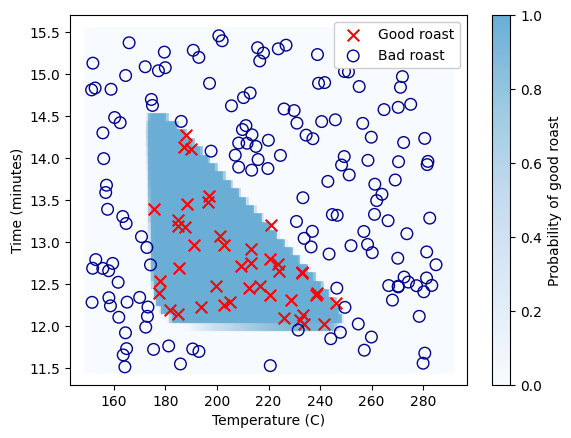

In [44]:
# plotting prediction map with training data => change c=y_pred_np - our new predictions
fig, ax = plt.subplots()
sc = ax.scatter(X_pred[:,0], X_pred[:,1], c=y_pred_np, cmap=new_cmap, marker='s', norm=cm.colors.Normalize(vmin=0, vmax=1))
ax.scatter(good_roast.Temperature, good_roast.Time, s=70, marker='x', c='r', label='Good roast')
ax.scatter(bad_roast.Temperature, bad_roast.Time, s=70, marker='o', label='Bad roast', facecolors='none', edgecolors='darkblue')
ax.set(ylabel = 'Time (minutes)',
       xlabel = 'Temperature (C)')
ax.legend(loc='upper right', bbox_to_anchor=(1.0, 1), fancybox=True, ncol=1, framealpha=1)
ax.figure.colorbar(sc, ax=ax, label= 'Probability of good roast')

##### Nice, the graph looks very similar! Now print whether get all predictions the same

In [42]:
print(((y_pred_np>=0.5).astype(int)==(y_pred>=0.5).astype(int)).all())

True
